In [45]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import matplotlib.pyplot as plt
import math
import SALib
from scipy.optimize import fsolve
from scipy.constants import N_A

In [46]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*100000000
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

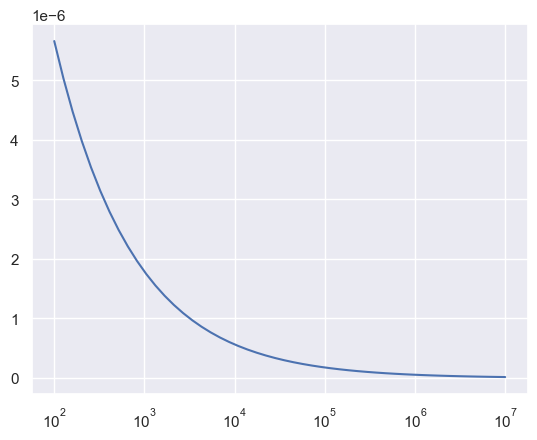

In [47]:
rtots = np.geomspace(1e2, 1e7)

plt.semilogx(rtots, 4*(np.sqrt((math.pi*((tumour_cell_radius)**2))/rtots)) - 1e-8 )

3.264752649189157e-05


ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

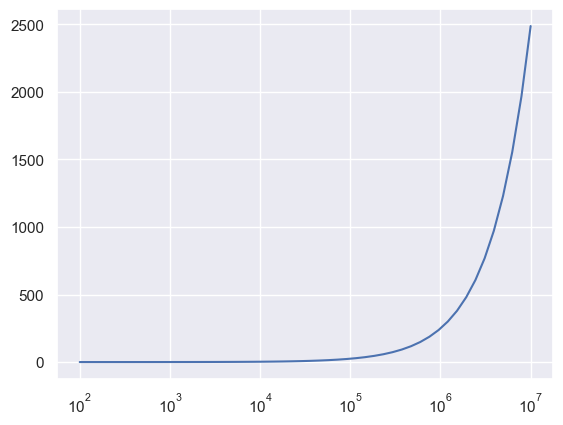

In [48]:
D = 1e-13
kon=1e5
r_ab = 1.25e-8
rtot = 1e5
reaction_volume = (2*math.pi*(r_ab**3))/3
Ageff = (1*rtot/N_A)*tumour_cell_surface_area/reaction_volume
print(Ageff)
plt.semilogx(rtots, 1/(2*math.pi*(tumour_cell_radius**2)/(D*rtots)), label='Diffusion')
plt.semilogx(rtots, Ageff, label = 'reaction volume')
plt.xlabel(r'$r^{tot}$')
plt.legend(loc='best')


In [ ]:
rtot = 1e2
(np.sqrt((4*math.pi*((tumour_cell_radius)**2))/rtot))

2.8359261614488256e-06

In [65]:
def model_R_monospecific(t, z, Ainit, kon, koff, r_ab, rtot):
    k = Ainit*kon
    Atot = well_size*N_A*Ainit/Target_cell_number
    reaction_volume = (2*math.pi*(r_ab**3))/3
    A0 = Atot - z[0] - z[1] 
    Ag = rtot - z[0] - 2*z[1]
    target_effective_conc1 =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
    k2 = target_effective_conc1*kon
    dA10 = 2*(k*Ag*A0/(Atot)) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
    dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

    return [dA10, dA11]

In [ ]:
def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = (-2*Atot*k1*Ainit*(rtot - x)*(koff*rtot + k2*x) + x*(((koff*rtot + k2*x)**2) +k1*Ainit*(rtot - x)*(2*koff*rtot + k2*(rtot+x))))/((koff*rtot + k2*x)**2)

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff*rtot + k2*x))

    return express

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'r_ab', 'koff', 'dummy'],
    'bounds': [[1e3, 1e7],
               [1e4, 1e6],
               [2e-11, 2e-7],
               [1e-6, 1e-1],
               [1, 1000]]
}

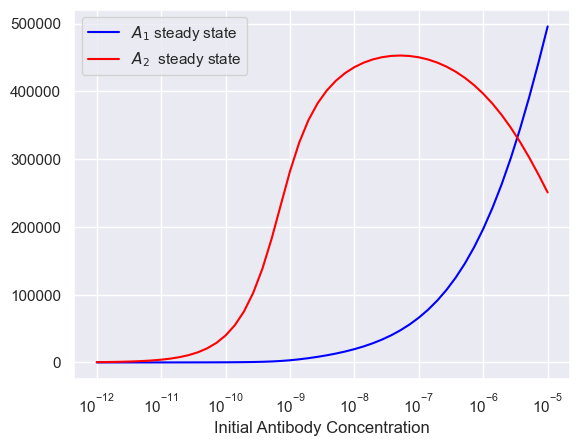

In [69]:
A0s = np.geomspace(1e-12, 1e-5, 50)

A1_st_sim = np.zeros_like(A0s)
A1_st_root = np.zeros_like(A0s)
A2_st_sim = np.zeros_like(A0s)
A2_st_root = np.zeros_like(A0s)


for i, Ainit in enumerate(A0s):

    #A1_st_root[i] = fsolve(A1_steady_state, [0], args=(Ainit, 1e5, 1e-4, 1e2, 1e5, 0))
    #A2_st_root[i] = A2_steady_state(A1_st_root[i], 1e1, 1e-4, 1e5)
    z = solve_ivp(model_R_monospecific, tspan, [0,0], method='Radau', t_eval=t, args=(Ainit, 1e5, 1e-4, 2.5e-8, 1e6))
    A1 = z.y[0]
    A2 = z.y[1]
    A1_st_sim[i] = A1[-1]
    A2_st_sim[i] = A2[-1]

sns.set_theme()
plt.plot(A0s, A1_st_sim , label = r'$A_1$' + ' steady state', color='blue')
#plt.plot(A0s, A1_st_root, label = 'A1 calculated root')
plt.plot(A0s, A2_st_sim, label = r'$A_2$ ' + ' steady state', color='red')
#plt.plot(A0s, A2_st_root, label = 'A2 calculated root')

plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Initial Antibody Concentration')
plt.show()

In [ ]:
vals = SALib.sample.sobol.sample(problem1, 262144)
Y_ag1 = np.zeros(len(vals))
Y_ag2 = np.zeros(len(vals))
Y_ab = np.zeros(len(vals))
indicies_ag1 = []
indicies_ag2 = []
indicies_ab = []
A0s = [1e-11, 1e-10, 1e-9]#, 1e-8, 1e-7, 1e-6, 1e-5]
A0s = [1e-6, 1e-5]
Y = np.zeros(len(vals))
indicies = []
indicies_1 = []

In [ ]:
16384*16

262144

In [ ]:
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
      
        rtot = params[0]
        kon = params[1]
        r_ab = params[2]
        koff = params[3]
        dummy = params[4]

        reaction_volume = (2/3)*math.pi*((r_ab)**3)
        target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
        k2 = target_effective_conc*kon

        if Ainit < 1e-8:
            guess = 0
        else:
            guess = 1

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag = (A1_st + 2*A2_st)/rtot
        Y[i] = Ag
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])


1e-06


KeyboardInterrupt: 

In [ ]:
16384*2*2

65536

In [ ]:
(3*1e4*1e3*tumour_cell_surface_area/(2*1e4*N_A*math.pi))**(1/3)

8.607164580321545e-11

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (3,).

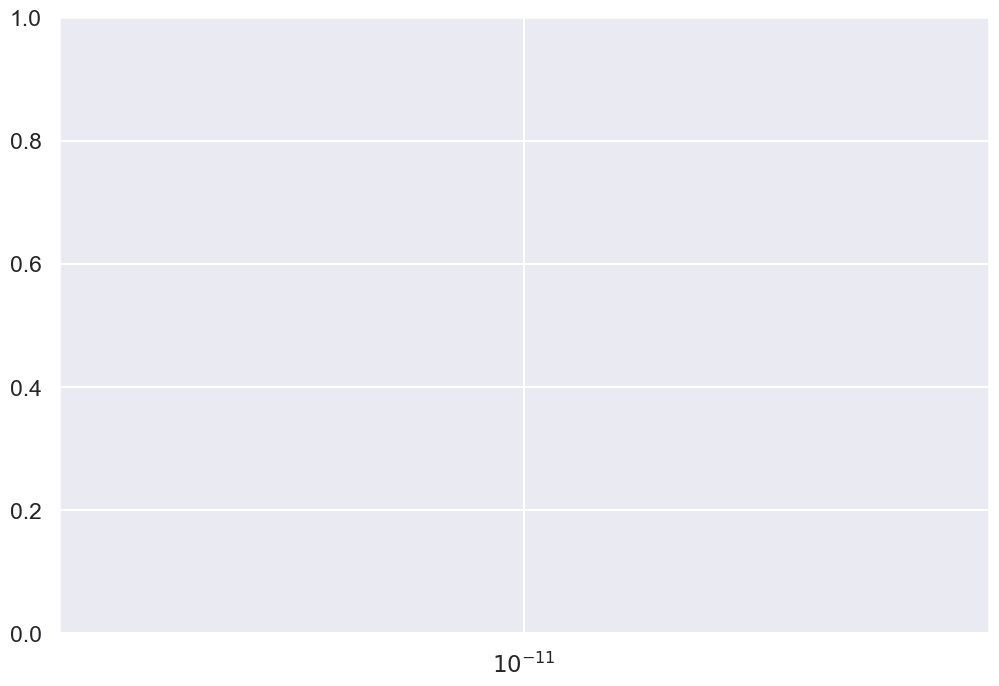

In [ ]:
kon1_si = np.zeros(len(A0s))
koff1_si = np.zeros(len(A0s))
rtot1_si = np.zeros(len(A0s))
r_ab_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies)):
    vals = indicies[i]
    rtot1_si[i] = vals[0]
    kon1_si[i] = vals[1]
    r_ab_si[i] = vals[2]
    koff1_si[i] = vals[3]
    dummy_si[i] = vals[4]

ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon1_si,
    r"$k^{off}$": koff1_si,
}

sns.set_theme()
sns.set_context("talk")
width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie

ax.bar(ab_conc, r_ab_si, width, label=r'$r^{ab}$', bottom= bottom, color='red')
bottom+= r_ab_si
ax.bar(ab_conc, rtot1_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot1_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.set_title('Model R Receptor Occupancy Sobol Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('Total Order Sobol Indicies')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_bispecific_total_ab_sensiv_analysis.png')

Text(0, 0.5, 'First Order Sobol Indicies')

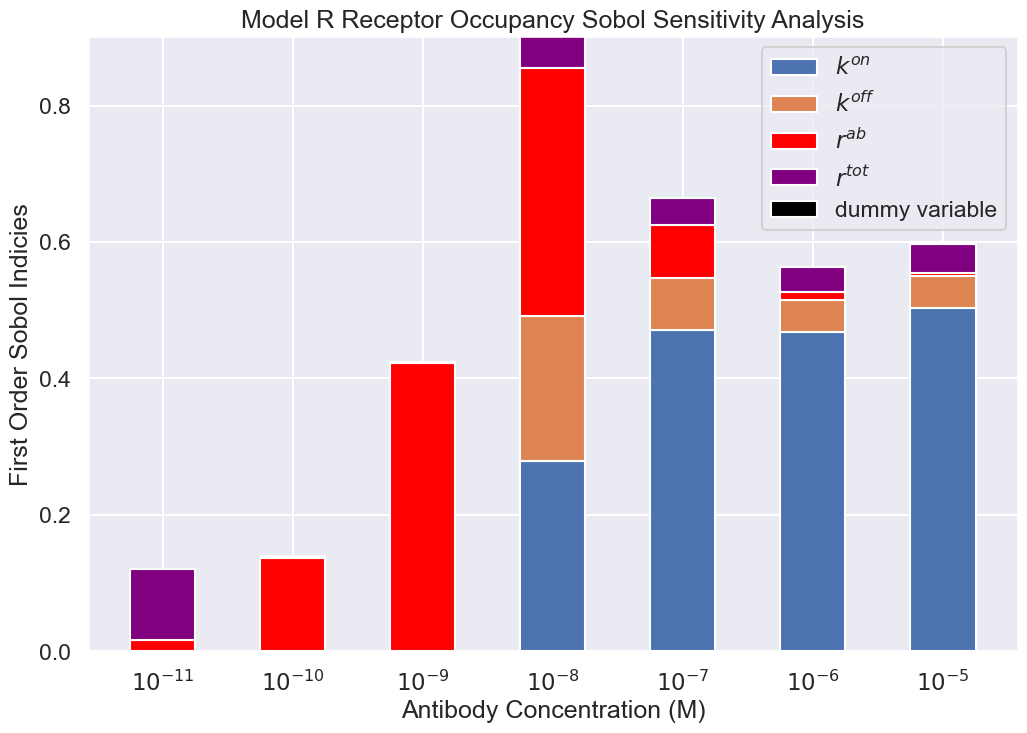

In [ ]:
kon1_si = np.zeros(len(A0s))
koff1_si = np.zeros(len(A0s))
rtot1_si = np.zeros(len(A0s))
r_ab_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies_1)):
    vals = indicies_1[i]
    rtot1_si[i] = vals[0]
    kon1_si[i] = vals[1]
    r_ab_si[i] = vals[2]
    koff1_si[i] = vals[3]
    dummy_si[i] = vals[4]

ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon1_si,
    r"$k^{off}$": koff1_si,
}

sns.set_theme()
sns.set_context("talk")
width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie

ax.bar(ab_conc, r_ab_si, width, label=r'$r^{ab}$', bottom= bottom, color='red')
bottom+= r_ab_si
ax.bar(ab_conc, rtot1_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot1_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.set_title('Model R Receptor Occupancy Sobol Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('First Order Sobol Indicies')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_bispecific_total_ab_sensiv_analysis.png')